In [1]:
year = None
month = None
program = "prepilot"

In [2]:
from collections import defaultdict
import datetime

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.distributions as dist
from biogeme.expressions import Beta, DefineVariable, RandomVariable, bioDraws, log, MonteCarlo, Integrate
import biogeme.results as res
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import scaffolding
from uuid import UUID

%matplotlib inline

Connecting to database URL db


## Collect Data From Database

In [3]:
# Loading mapping dictionaries from mapping_dictionaries notebook
# Dictionary map is putting all other replaced modes into other
%store -r df_EI
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_re = defaultdict(lambda: 'Other',dic_re)

In [4]:
tq = scaffolding.get_time_query(year, month)

In [5]:
stage_uuids = []
for ue in edb.get_uuid_db().find():
    if ue['user_email'].startswith("stage_"):
        stage_uuids.append(str(ue['uuid']))
stage_uuids

['2bc8ca71-7d0f-4930-ba2c-cf97f7dceaea',
 'b0c98c51-4bb9-4c67-9ec3-7814cfbdfc82',
 'd4376620-fbcd-4aab-95bf-8c2e0ecf9adf',
 '802667b6-371f-45b2-9c7a-bb051244836a',
 '1fdbfb17-5168-445a-8c2b-14efd528ccdd',
 'cc46e76f-10a1-4376-8548-0b909b290ba0',
 'edf65849-3a6e-406a-8e4e-19044ab01ba5',
 '6373dfb8-cb9b-47e8-8e8f-76adcfadde20',
 '93c6e0f1-56a4-4e07-b920-ded664419dc6',
 'e89976df-90c0-4e04-87bf-f81ccd2e36d4',
 '73c7bf7e-2552-4a6d-b211-62190d2322e2',
 '29d04974-ff70-4c61-a0b0-dafcc1d23ec8',
 '0118ea1d-1a13-4e61-b99a-d68ac08e883f',
 '87cb8852-9b61-4c0e-91ec-07a33145659b',
 '656d997c-5122-4526-9874-9949b1f50fe5',
 'ce0f2630-4819-4bca-afa3-291b9f25da93',
 'd22cd8f0-1857-4796-ab27-6aa59cd1e1b3',
 'ae91f6bc-b25d-4d80-93ba-0159ac220901',
 'c49a0a47-6bfa-4fa1-94c9-b850c97dbfb4',
 '1ac2dbad-b3cb-4597-89af-f4de4340b5f0',
 '9aa33ec1-c02d-437d-9b65-389e20beaa00',
 '7ac4a17a-985f-46b4-9114-c139305aae29',
 '5f0ceaa8-d604-426b-b9a9-49629d6a085f',
 '659974c8-053a-48ba-a6c6-a3cc4fa31004',
 '37ae3762-24e7-

In [6]:
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

[UUID('863e9c6c-8ec0-48c4-b765-3f73d839c85b'),
 UUID('c6e4db31-c18b-4355-b02a-7dd97deca70b'),
 UUID('c6807997-194c-4c52-8a8f-a8c1f6ee1595'),
 UUID('e9e479e9-5c3f-4345-a885-dadb7999b312'),
 UUID('6656c04c-6cba-4c18-9fed-805eaa529741'),
 UUID('9910245f-ee4e-4cca-ab4c-dd2312eb0d5d'),
 UUID('9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98'),
 UUID('509b9093-9093-4e98-8eb1-20b58ed9bd8c'),
 UUID('e192b8a0-0b6c-4222-9685-1c93785deaf7'),
 UUID('2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d'),
 UUID('56e23e21-6152-4f59-9253-50bd28a5d7f9'),
 UUID('840297ae-3948-4e26-bfeb-e83ee30c5b3e'),
 UUID('d7a732f4-a864-4bcb-b8de-dfc8be242fb2'),
 UUID('5ad862e7-9a63-41f6-9f28-c0096fe884da'),
 UUID('21c78a1c-6df2-4097-b289-5a784610991b'),
 UUID('e4cfb2a8-f600-4268-9756-9985e234636e'),
 UUID('fc68a5bb-0a7b-4b63-86b3-f08a69ead36f'),
 UUID('321b7e37-a9a1-4775-9ebb-b5dc88e183fb'),
 UUID('28cb1dde-8551-4bba-bfd4-2145bdaf7e0a'),
 UUID('e35e6510-7a34-496d-b49f-a5a0b41a1e9e'),
 UUID('d3735ba2-12dd-4c76-8e16-75dca7bdcb6f'),
 UUID('97953a

Loaded all confirmed trips of length 115517


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 115517 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


In [7]:
# Remove stage users (appears to be no difference)
test = participant_ct_df[~participant_ct_df['user_id'].isin(stage_uuids)]
print(len(test))
print(len(participant_ct_df))

115517
115517


In [8]:
# labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)
# expanded_ct = scaffolding.expand_userinputs(labeled_ct)

In [9]:
# Use sensed as well as labeled trips
expanded_ct = scaffolding.expand_userinputs(participant_ct_df)

,mode_confirm,purpose_confirm,replaced_mode
0,drove_alone,work,NaN
1,drove_alone,home,NaN
2,drove_alone,work,NaN
3,drove_alone,meal,NaN
4,drove_alone,meal,NaN


After expanding, columns went from 38 -> 41


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,drove_alone,work,NaN
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,drove_alone,home,NaN
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,drove_alone,work,NaN
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,drove_alone,meal,NaN
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,drove_alone,meal,NaN


In [11]:
expanded_ct = scaffolding.data_quality_check(expanded_ct)
expanded_ct.shape

(115517, 41)

In [12]:
# Apply sensed mode where not filled in
inferred_modes = []
for i in range(0,len(expanded_ct)):
    try:
        inferred_modes.append(expanded_ct['inferred_labels'].iloc[i][0]['labels']['mode_confirm'])
    except:
        inferred_modes.append(None)

expanded_ct['Inferred_mode'] = inferred_modes
expanded_ct.mode_confirm.fillna(expanded_ct.Inferred_mode, inplace=True)

In [13]:
# Mapping new labels with dictionaries
expanded_ct['Trip_purpose'] = expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm'] = expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode'] = expanded_ct['replaced_mode'].map(dic_re)

# Mapping fuel
expanded_ct['Mode_confirm_fuel'] = expanded_ct['Mode_confirm'].map(dic_fuel)
expanded_ct['Replaced_mode_fuel'] = expanded_ct['Replaced_mode'].map(dic_fuel)

In [14]:
# Change meters to miles
scaffolding.unit_conversions(expanded_ct)

In [15]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_prepilot
Based on 115517 confirmed trips from 190 users
of 115517 total trips from 190 users (100.00%)


In [16]:
# Calculate energy impact
expanded_ct = scaffolding.energy_intensity(expanded_ct, df_EI, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')

In [17]:
# Join the expanded database data to socioeconomic data
socio_data = pd.read_csv('./replacement_modeling/Can Do Colorado eBike Program - en.csv')
socio_data.rename(columns={'Unique User ID (auto-filled, do not edit)':'user_id',
                          'Please identify which category represents your total household income, before taxes, for last year.':'HHINC',
                          'How many motor vehicles are owned, leased, or available for regular use by the people who currently live in your household?':'VEH',
                           'In which year were you born?':'AGE',
                          'Including yourself, how many people live in your home?':'HHSIZE',
                          'How many children under age 18 live in your home?':'CHILDREN',
                          'What is your gender?':'GENDER',
                          'If you were unable to use your household vehicle(s), which of the following options would be available to you to get you from place to place?':'available_modes',
                          'Are you a student?':'STUDENT'}, inplace=True)
socio_data = socio_data[~socio_data.user_id.isnull()]

# Deal with people who have multiple responses by using most recent
socio_data = socio_data.sort_values(by=['user_id', 'Timestamp'])
socio_data.drop_duplicates(subset=['user_id'], keep='last', inplace=True)

# Lose 15000 trips due to people with no survey responses
expanded_ct.user_id = expanded_ct.user_id.astype(str)
expanded_ct.user_id = [i.replace('-','') for i in expanded_ct.user_id] # remove all dashes from strings
expanded_ct = expanded_ct.merge(socio_data, on='user_id')

In [18]:
expanded_ct.columns

Index(['source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts',
       'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place',
       'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip',
       'expectation', 'confidence_threshold', 'expected_trip', 'user_input',
       'start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
       'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
       'start_local_dt_weekday', 'start_local_dt_timezone',
       'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
       'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
       'end_local_dt_weekday', 'end_local_dt_timezone', '_id', 'user_id',
       'metadata_write_ts', 'mode_confirm', 'purpose_confirm', 'replaced_mode',
       'Inferred_mode', 'Trip_purpose', 'Mode_confirm', 'Replaced_mode',
       'Mode_confirm_fuel', 'Replaced_mode_fuel', 'distance_miles',
       'ei_Replaced_mode', 'CO2_Replaced_

## Data Preprocessing

In [57]:
# Select variables of interest from complete OpenPATH data
data = expanded_ct[['Mode_confirm','Replaced_mode','replaced_mode','Trip_purpose','duration','distance_miles','start_local_dt_weekday','available_modes','AGE','HHINC','VEH','HHSIZE','CHILDREN','GENDER','STUDENT','user_id','start_local_dt_year','start_local_dt_month','start_local_dt_day']].copy()

# Get timestamp from known year/month/day aggregated to days
data.rename(columns={'start_local_dt_year':'year','start_local_dt_month':'month','start_local_dt_day':'day'}, inplace=True)
data['date_time'] = pd.to_datetime(data[['year','month','day']])
data = data.drop(columns=['year','month','day'])

# Fix age
data['AGE'] = 2022 - data['AGE']

# Get number of workers
data['WORKERS'] = data['HHSIZE'] - data['CHILDREN']

# Duration in minutes
data['duration'] = data['duration'] / 60

# Filter out some responses to data
data = data[~data['Mode_confirm'].isin(['Not a Trip','Other'])]
# data = data[~data['Trip_purpose'].isin(['not_a_trip','Other'])]
# data = data[~data['Replaced_mode'].isin(['Not a Trip','Other'])]
# data = data[~data['HHINC'].isin(['Prefer not to say'])]
# data = data[~data['VEH'].isin(['Prefer not to say / Prefiero no decir.'])]
data = data[~data['available_modes'].isin(['None'])]

# Combine variable categories
data = data.replace('Car, drove alone', 'car')
data = data.replace('Car, with others', 'car')
data = data.replace('Bikeshare', 's_micro')
data = data.replace('Scooter share', 's_micro')
data = data.replace('Regular Bike', 'p_micro')
data = data.replace('Skate board', 'p_micro')
data = data.replace('Train', 'transit')
data = data.replace('Free Shuttle', 'transit')
data = data.replace('Bus', 'transit')
data = data.replace('Walk', 'walk')
data = data.replace('Taxi/Uber/Lyft', 'ridehail')
data = data.replace('Pilot ebike', 'ebike')

# data = data.replace(['Home','School','Work'], 'hbw')
# data = data.replace(['Entertainment/Social','Meal','Personal/Medical','Pick-up/Drop off','Recreation/Exercise','Religious','Shopping','Transit transfer'], 'non_hbw')

# data['start_local_dt_weekday'] = data['start_local_dt_weekday'].replace(['1','2','3','4','5'],'1')
# data['start_local_dt_weekday'] = data['start_local_dt_weekday'].replace(['0','6'],'0')

# data = data.replace(['By hours ','Custodian','Fire Fighter 2 Training',
#  'Graduate','Prefer not to say','Taking prerequisites missing for grad program ',
#  'Yes - Full Time College/University',
#  'Yes - Part-Time College/University',
#  'Yes - Vocation/Technical/Trade School',
#  'taking classes toward early childhood licensure'], 'student')
# data = data.replace('Not a student', 'non_student')

# Calculate travel times for each trip, across every mode
def add_all_mode_tt(data, mode_col, duration_col, dist_col):
    mode_travel_times = {}
    for mode in pd.unique(data[mode_col]):

        # Linear model for duration based on distance for trips belonging to each mode
        mode_data = data[data[mode_col]==mode]
        regr = linear_model.LinearRegression()
        regr.fit(mode_data[dist_col].values.reshape(-1,1), mode_data[duration_col].values.reshape(-1,1))

        # Make prediction for ALL trips
        mode_duration_pred = regr.predict(data[dist_col].values.reshape(-1,1))
        mode_travel_times['tt_'+mode] = mode_duration_pred

    # Apply for each mode existing in the dataframe
    for mode in mode_travel_times:
        data[mode] = mode_travel_times[mode]

    return data

# Calculate all mode travel times and add to dataframe
data = add_all_mode_tt(data,'Mode_confirm','duration','distance_miles')

# Calculate vehicle costs based roughly on $/mi from: https://www.vtpi.org/tca/tca0501.pdf
cost_factors = {'car':0.80,
               'ridehail':3.00,
               's_micro':1.50,
               'transit':0.40}

def add_all_mode_cost(data, cost_factors, dist_col):
    for factor in cost_factors:
        data['cost_'+factor] = cost_factors[factor] * data[dist_col]
    return data

# Calculate all mode travel costs and add to dataframe
add_all_mode_cost(data, cost_factors, 'distance_miles')

# Labels for modes in the availability survey
availability_codes = {'Public transportation (bus, subway, light rail, etc.)':'transit',
                    'Get a ride from a friend or family member':'car',
                    'Rental car (including Zipcar/ Car2Go)':'car',
                    'Taxi (regular taxi, Uber, Lyft, etc)':'ridehail',
                    'Bicycle':'p_micro',
                    'Shared bicycle or scooter':'s_micro',
                    'Walk/roll':'walk',
                    'Skateboard':'p_micro'}

# Create columns for available modes under each trip
def add_mode_availability(data, availability_codes, availability_col, choice_col, replaced_col):
    mode_list = np.unique(list(availability_codes.values()))
    available_list = data[availability_col].values
    choice_list = data[choice_col].values
    replaced_list = data[replaced_col].values
    for mode in mode_list:
        mode_avail = []
        i=0
        for available in available_list:
            if 'None' in available:
                mode_avail.append(1)
                i+=1
                continue
            options = [availability_codes[x] for x in available.split(';')]
            # Chosen mode must be in the available modes list, if mode was chosen it is assumed available
            # SWAP THIS LINE TO INCLUDE REPLACED MODE IN THE CHOICE SET (FOR VISUALS AT END)
            if mode in options or mode==choice_list[i] or mode==replaced_list[i]:
#             if mode in options or mode==choice_list[i]:
                mode_avail.append(1)
            else:
                mode_avail.append(0)
            i+=1
        data['av_'+mode] = mode_avail

    return data

# Add availability variables to data
data = add_mode_availability(data, availability_codes, 'available_modes', 'Mode_confirm', 'Replaced_mode')

In [58]:
# Handle all variables that are ordinal; otherwise they may not end up in correct order
# data.HHINC = pd.Categorical(data.HHINC,
#                             ordered=True,
#                             categories=['Less than $24,999',
#                                        '$25,000-$49,999',
#                                        '$50,000-$99,999',
#                                        '$100,000 -$149,999',
#                                        '$150,000-$199,999',
#                                        '$200,000 or more'])
# data.VEH = pd.Categorical(data.VEH,
#                             ordered=True,
#                             categories=['0',
#                                        '1',
#                                        '2',
#                                        '3',
#                                        '4+'])

# Make sure that the confirmed and replaced modes align after being converted to numeric variables
data.Mode_confirm = pd.Categorical(data.Mode_confirm,
                            ordered=True,
                            categories=['car',
                                       'p_micro',
                                       'ridehail',
                                       's_micro',
                                       'transit',
                                       'walk',
                                       'ebike'])
data.Replaced_mode = pd.Categorical(data.Replaced_mode,
                            ordered=True,
                            categories=['car',
                                       'p_micro',
                                       'ridehail',
                                       's_micro',
                                       'transit',
                                       'walk',
                                       'ebike',
                                       'No Travel'])

In [59]:
# Convert categorical variables to numeric
cat_columns = data.select_dtypes(['object','category']).columns
all_categories = []
for i in range(0,len(cat_columns)):
    # Keep a record of what order the categories are in when converted
    var_categories = data[cat_columns].astype('category').iloc[:,i].cat.categories
    all_categories.append(var_categories)
data[cat_columns] = data[cat_columns].apply(lambda x: x.astype('category').cat.codes)

# Show listed categories in their order
print(cat_columns)
print(all_categories)

Index(['Mode_confirm', 'Replaced_mode', 'replaced_mode', 'Trip_purpose',
       'available_modes', 'HHINC', 'VEH', 'GENDER', 'STUDENT', 'user_id'],
      dtype='object')
[Index(['car', 'p_micro', 'ridehail', 's_micro', 'transit', 'walk', 'ebike'], dtype='object'), Index(['car', 'p_micro', 'ridehail', 's_micro', 'transit', 'walk', 'ebike',
       'No Travel'],
      dtype='object'), Index(['bike', 'bikeshare', 'bus', 'call_friend', 'car', 'doing_nothing',
       'drove_alone', 'e_bike', 'ebike', 'emergency_vehicle with others',
       'family', 'free_shuttle', 'hiking', 'home', 'i_walked to the toilet',
       'lunch', 'meal', 'must_walk 3-5 mi a day for back', 'n/a',
       'no_replacement', 'no_travel', 'nothing._delivered food for work',
       'pilot_bike', 'pilot_e-bike', 'pilot_ebike', 'plane', 'rental_car',
       'scootershare', 'shared_ride', 'skateboard', 'taxi', 'testing',
       'time_spent on the clock at amazon', 'train', 'train_+ bus', 'walk',
       'walking_at work', 'w

In [60]:
data.isna().sum()

Mode_confirm              0
Replaced_mode             0
replaced_mode             0
Trip_purpose              0
duration                  0
distance_miles            0
start_local_dt_weekday    0
available_modes           0
AGE                       0
HHINC                     0
VEH                       0
HHSIZE                    0
CHILDREN                  0
GENDER                    0
STUDENT                   0
user_id                   0
date_time                 0
WORKERS                   0
tt_car                    0
tt_ebike                  0
tt_walk                   0
tt_p_micro                0
tt_transit                0
tt_s_micro                0
tt_ridehail               0
cost_car                  0
cost_ridehail             0
cost_s_micro              0
cost_transit              0
av_car                    0
av_p_micro                0
av_ridehail               0
av_s_micro                0
av_transit                0
av_walk                   0
dtype: int64

In [233]:
# Remove unlabeled replacement trips (to be labeled after modeling)
df_rep_unlabeled = data
data = data[~data['Replaced_mode'].isin([-1])]

# Remove ebike (mode 6) trips from data (assume ebike would not be chosen to replace ebike)
df_non_ebike = data[~data['Mode_confirm'].isin([6])]
df_train, df_test = train_test_split(df_non_ebike, test_size=0.1)

## Run Random Forest Classifier

In [234]:
feature_list = ['tt_car','tt_walk','tt_p_micro','tt_transit','tt_s_micro','tt_ridehail',
             'cost_car','cost_ridehail','cost_s_micro','cost_transit',
             'av_car','av_walk','av_p_micro','av_transit','av_s_micro','av_ridehail']

In [235]:
Y = df_train[['Mode_confirm']].values.flatten()
X = df_train[feature_list].values

Y_test = df_test[['Mode_confirm']].values.flatten()
X_test = df_test[feature_list].values

In [236]:
# Train random forest on non-ebike trip training set
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X,Y);

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: av_car               Importance: 0.12
Variable: cost_s_micro         Importance: 0.09
Variable: tt_car               Importance: 0.08
Variable: tt_walk              Importance: 0.08
Variable: tt_ridehail          Importance: 0.08
Variable: cost_ridehail        Importance: 0.08
Variable: tt_p_micro           Importance: 0.07
Variable: tt_transit           Importance: 0.07
Variable: tt_s_micro           Importance: 0.07
Variable: cost_car             Importance: 0.07
Variable: cost_transit         Importance: 0.07
Variable: av_walk              Importance: 0.06
Variable: av_p_micro           Importance: 0.03
Variable: av_ridehail          Importance: 0.02
Variable: av_transit           Importance: 0.01
Variable: av_s_micro           Importance: 0.01


In [237]:
# Test random forest on the test set
Y_pred = rf.predict(X_test)
accuracy = sum(Y_pred==Y_test) / len(Y_test)
print(f"Accuracy on Primary Choice: {accuracy}")

Accuracy on Primary Choice: 0.7985153764581124


In [238]:
# Test random forest on the replaced mode
df_ebike = data[data['Mode_confirm']==6]
df_ebike_new_trips = df_ebike[~df_ebike['Replaced_mode'].isin([6,7])]
Y_rep = df_ebike_new_trips['Replaced_mode'].values.flatten()
X_rep = df_ebike_new_trips[feature_list].values
Choice_rep = df_ebike_new_trips['Mode_confirm'].values

In [239]:
# # This is actually unnecessary since chosen mode is ebike which is not an option in model
# # Returns highest probability mode that is not the chosen mode
# # Needs restructure to also iterate over choice array
# def replaced_mode_prediction(class_probs, choice):
#     best_alt = None
#     best_prob = -1
#     for i in range(0,len(class_probs)):
#         if (class_probs[i] > best_prob) and (i != choice):
#             best_alt = i
#             best_prob = class_probs[i]    
#     return best_alt

# simulatedValues = rf.predict_proba(X_rep)
# result = np.apply_along_axis(replaced_mode_prediction, choice=Choice_rep, axis=1, arr=simulatedValues)

In [240]:
# Test random forest on the test set stated replaced mode
Y_rep_pred = rf.predict(X_rep)
accuracy = sum(Y_rep_pred==Y_rep) / len(Y_rep)
print(f"Accuracy on Replaced Choice: {accuracy}")

Accuracy on Replaced Choice: 0.5954265611257695


## Run Biogeme Model

In [241]:
df_train_biogeme = df_train.drop(columns=['date_time'])
df_test_biogeme = df_test.drop(columns=['date_time'])
database_train = db.Database('openpath_trips', df_train_biogeme)
database_test = db.Database('openpath_trips', df_test_biogeme)
globals().update(database_train.variables)
globals().update(database_test.variables)

In [242]:
# Multinomial logit model in Biogeme

# Alternative specific constants
ASC_CAR = Beta('ASC_CAR',0,None,None,1)
ASC_EBIKE = Beta('ASC_EBIKE',0,None,None,0)
ASC_P_MICRO = Beta('ASC_P_MICRO',0,None,None,0)
ASC_RIDEHAIL = Beta('ASC_RIDEHAIL',0,None,None,0)
ASC_S_MICRO = Beta('ASC_S_MICRO',0,None,None,0)
ASC_TRANSIT = Beta('ASC_TRANSIT',0,None,None,0)
ASC_WALK = Beta('ASC_WALK',0,None,None,0)

# Trip parameters
B_COST = Beta('B_COST',0,None,None,0)
B_TT = Beta('B_TT',0,None,None,0)
B_PURP = Beta('B_PURP',0,None,None,0)
B_WKND = Beta('B_WKND',0,None,None,0)

# Individual parameters
B_AGE = Beta('B_AGE',0,None,None,0)
B_INC = Beta('B_INC',0,None,None,0)
B_VEH = Beta('B_VEH',0,None,None,0)
B_GENDER = Beta('B_GENDER',0,None,None,0)
B_WORKERS = Beta('B_WORKERS',0,None,None,0)
B_STUDENT = Beta('B_STUDENT',0,None,None,0)

B_ASV_TT_MOTOR = Beta('B_ASV_TT_MOTOR',0,None,None,1)
B_ASV_TT_PHYS = Beta('B_ASV_TT_PHYS',0,None,None,0)

B_ASV_NP_PHYS = Beta('B_ASV_NP_PHYS',0,None,None,1)
B_ASV_P_PHYS = Beta('B_ASV_P_PHYS',0,None,None,0)

# Alternative Specific Variables
B_ASV_VEH_CAR = Beta('B_ASV_VEH_CAR',0,None,None,1)
B_ASV_VEH_EBIKE = Beta('B_ASV_VEH_EBIKE',0,None,None,0)
B_ASV_VEH_P_MICRO = Beta('B_ASV_VEH_P_MICRO',0,None,None,0)
B_ASV_VEH_RIDEHAIL = Beta('B_ASV_VEH_RIDEHAIL',0,None,None,0)
B_ASV_VEH_S_MICRO = Beta('B_ASV_VEH_S_MICRO',0,None,None,0)
B_ASV_VEH_TRANSIT = Beta('B_ASV_VEH_TRANSIT',0,None,None,0)
B_ASV_VEH_WALK = Beta('B_ASV_VEH_WALK',0,None,None,0)

B_ASV_HHINC_CAR = Beta('B_ASV_HHINC_CAR',0,None,None,1)
B_ASV_HHINC_EBIKE = Beta('B_ASV_HHINC_EBIKE',0,None,None,0)
B_ASV_HHINC_P_MICRO = Beta('B_ASV_HHINC_P_MICRO',0,None,None,0)
B_ASV_HHINC_RIDEHAIL = Beta('B_ASV_HHINC_RIDEHAIL',0,None,None,0)
B_ASV_HHINC_S_MICRO = Beta('B_ASV_HHINC_S_MICRO',0,None,None,0)
B_ASV_HHINC_TRANSIT = Beta('B_ASV_HHINC_TRANSIT',0,None,None,0)
B_ASV_HHINC_WALK = Beta('B_ASV_HHINC_WALK',0,None,None,0)

# Utility functions
V0 = ASC_CAR + \
B_COST * cost_car + \
B_ASV_TT_MOTOR * tt_car

V1 = ASC_P_MICRO + \
B_ASV_TT_PHYS * tt_p_micro

V2 = ASC_RIDEHAIL + \
B_COST * cost_ridehail + \
B_ASV_TT_MOTOR * tt_ridehail

V3 = ASC_S_MICRO + \
B_COST * cost_s_micro + \
B_ASV_TT_PHYS * tt_s_micro

V4 = ASC_TRANSIT + \
B_COST * cost_transit + \
B_ASV_TT_MOTOR * tt_transit

V5 = ASC_WALK + \
B_ASV_TT_PHYS * tt_walk

# Map modes to utility functions
V = {0: V0,
    1: V1,
    2: V2,
    3: V3,
    4: V4,
    5: V5}

# Mode availability
av = {0: av_car,
    1: av_p_micro,
    2: av_ridehail,
    3: av_s_micro,
    4: av_transit,
    5: av_walk}

In [243]:
# Train the model parameters
logprob = models.loglogit(V, av, Mode_confirm)
biogeme = bio.BIOGEME(database_train, logprob)
biogeme.modelName = 'openpath_mnl'
biogeme.generateHtml = True
biogeme.generatePickle = True
results = biogeme.estimate()

In [244]:
# # Mixed logit model in Biogeme
# # Best so far: openpath_mxl~05

# # Alternative specific constants
# ASC_CAR = Beta('ASC_CAR',0,None,None,1)
# ASC_EBIKE = Beta('ASC_EBIKE',0,None,None,0)
# ASC_P_MICRO = Beta('ASC_P_MICRO',0,None,None,0)
# ASC_RIDEHAIL = Beta('ASC_RIDEHAIL',0,None,None,0)
# ASC_S_MICRO = Beta('ASC_S_MICRO',0,None,None,0)
# ASC_TRANSIT = Beta('ASC_TRANSIT',0,None,None,0)
# ASC_WALK = Beta('ASC_WALK',0,None,None,0)

# # Define a random parameter, normally distributed, designed to be used
# # for Monte-Carlo simulation
# B_TIME = Beta('B_TIME', 0, None, None, 0)
# B_COST = Beta('B_COST', 0, None, None, 0)

# # Alternative specific variables
# B_HHINC = Beta('B_HHINC', 0, None, None, 0)

# # It is advised not to use 0 as starting value for the following parameter.
# B_TIME_S = Beta('B_TIME_S', 1, None, None, 0)
# B_TIME_RND = B_TIME + B_TIME_S * bioDraws('B_TIME_RND', 'NORMAL')

# # Utility functions
# V0 = ASC_CAR + \
# B_TIME_RND * tt_car + \
# B_COST * cost_car

# V1 = ASC_P_MICRO + \
# B_TIME_RND * tt_p_micro

# V2 = ASC_RIDEHAIL + \
# B_TIME_RND * tt_ridehail + \
# B_COST * cost_ridehail

# V3 = ASC_S_MICRO + \
# B_TIME_RND * tt_s_micro + \
# B_COST * cost_s_micro

# V4 = ASC_TRANSIT + \
# B_TIME_RND * tt_transit + \
# B_COST * cost_transit

# V5 = ASC_WALK + \
# B_TIME_RND * tt_walk

# # Map modes to utility functions
# V = {0: V0,
#     1: V1,
#     2: V2,
#     3: V3,
#     4: V4,
#     5: V5}

# # Mode availability
# av = {0: av_car,
#     1: av_p_micro,
#     2: av_ridehail,
#     3: av_s_micro,
#     4: av_transit,
#     5: av_walk}

# # Conditional to B_TIME_RND, we have a logit model (called the kernel)
# prob = models.logit(V, av, Mode_confirm)

# # We integrate over B_TIME_RND using Monte-Carlo
# logprob = log(MonteCarlo(prob))

In [245]:
# # Train the model parameters
# biogeme = bio.BIOGEME(database_train, logprob)
# biogeme.modelName = 'openpath_mxl'
# biogeme.generateHtml = True
# biogeme.generatePickle = True
# results = biogeme.estimate()

## Evaluate Model Results

In [246]:
# # The estimation results are read from the pickle file
# results = res.bioResults(pickleFile='openpath_mxl~05.pickle')

### Test MXL Model

In [247]:
# # Conditional to B_TIME_RND, we have a logit model (called the kernel)
# prob = models.logit(V, av, Mode_confirm)

# # We calculate the integration error. Note that this formula assumes
# # independent draws, and is not valid for Haltom or antithetic draws.
# numberOfDraws = 1000
# integral = MonteCarlo(prob)
# integralSquare = MonteCarlo(prob * prob)
# variance = integralSquare - integral * integral
# error = (variance / 2.0) ** 0.5

# # And the value of the individual parameters
# numerator = MonteCarlo(B_TIME_RND * prob)
# denominator = integral

# simulate = {
#     'Numerator': numerator,
#     'Denominator': denominator,
#     'Integral': integral,
#     'Integration error': error,
# }

# # Create the Biogeme object
# biosim = bio.BIOGEME(database_test, simulate, numberOfDraws=numberOfDraws)
# biosim.modelName = "openpath_mxl_simul"

# # Simulate the requested quantities. The output is a Pandas data frame
# simresults = biosim.simulate(results.getBetaValues())

# # 95% confidence interval on the log likelihood.
# simresults['left'] = np.log(
#     simresults['Integral'] - 1.96 * simresults['Integration error']
# )
# simresults['right'] = np.log(
#     simresults['Integral'] + 1.96 * simresults['Integration error']
# )

# print(f'Log likelihood: {np.log(simresults["Integral"]).sum()}')
# print(
#     f'Integration error for {numberOfDraws} draws: '
#     f'{simresults["Integration error"].sum()}'
# )
# print(f'In average {simresults["Integration error"].mean()} per observation.')
# print(
#     f'95% confidence interval: [{simresults["left"].sum()}-'
#     f'{simresults["right"].sum()}]'
# )

# # Post processing to obtain the individual parameters
# simresults['beta'] = simresults['Numerator'] / simresults['Denominator']

# # Plot the histogram of individual parameters
# simresults['beta'].plot(kind='hist', density=True, bins=20)

# # Plot the general distribution of beta
# def normalpdf(v, mu=0.0, s=1.0):
#     """
#     Calculate the pdf of the normal distribution, for plotting purposes.

#     """
#     d = -(v - mu) * (v - mu)
#     n = 2.0 * s * s
#     a = d / n
#     num = np.exp(a)
#     den = s * 2.506628275
#     p = num / den
#     return p


# betas = results.getBetaValues(['B_TIME', 'B_TIME_S'])
# x = np.arange(simresults['beta'].min(), simresults['beta'].max(), 0.01)
# plt.plot(x, normalpdf(x, betas['B_TIME'], betas['B_TIME_S']), '-')
# plt.show()

### Test MNL Model

In [248]:
# Assemble utility functions for testing modes
prob_car = models.logit(V, av, 0)
prob_p_micro = models.logit(V, av, 1)
prob_ridehail = models.logit(V, av, 2)
prob_s_micro = models.logit(V, av, 3)
prob_transit = models.logit(V, av, 4)
prob_walk = models.logit(V, av, 5)

simulate ={'Prob. car': prob_car,
           'Prob. p_micro': prob_p_micro,
           'Prob. ridehail': prob_ridehail,
           'Prob. s_micro': prob_s_micro,
           'Prob. transit': prob_transit,
           'Prob. walk': prob_walk}

betas = results.getBetaValues()

In [249]:
# Calculate utility values for each row in the test database
biogeme = bio.BIOGEME(database_test, simulate)
biogeme.modelName = 'openpath_mnl_test'
simulatedValues = biogeme.simulate(betas)
simulatedValues

,Prob. car,Prob. p_micro,Prob. ridehail,Prob. s_micro,Prob. transit,Prob. walk
39290,0.676397,0.000000e+00,0.000000,0.000000e+00,0.036384,0.287219
30863,0.700451,2.625206e-02,0.000000,0.000000e+00,0.037623,0.235674
37660,0.634129,5.593168e-02,0.006634,0.000000e+00,0.034110,0.269195
57524,0.929071,1.583709e-07,0.010991,1.674516e-42,0.048871,0.011067
96639,0.000000,1.429720e-01,0.000000,0.000000e+00,0.099473,0.757555
...,...,...,...,...,...,...
11658,0.641848,0.000000e+00,0.006727,5.831792e-02,0.034514,0.258592
92118,0.680491,0.000000e+00,0.000000,0.000000e+00,0.036599,0.282910
69002,0.689631,2.827997e-02,0.007267,0.000000e+00,0.037048,0.237774
40479,0.883374,5.986531e-02,0.009265,0.000000e+00,0.047496,0.000000


In [250]:
# Test predicting maximum mode utility as choice
# Identify the column of highest probability, replace with number corresponding to the mode
prob_max = simulatedValues.idxmax(axis=1)
prob_max = prob_max.replace({'Prob. car': 0,
                             'Prob. p_micro': 1,
                             'Prob. ridehail':2,
                             'Prob. s_micro':3,
                             'Prob. transit':4,
                             'Prob. walk':5})
data_res = {'y_Actual':df_test['Mode_confirm'],'y_Predicted': prob_max}

# Test predicting car every time
data_res['y_Predicted_Car'] = np.repeat(0,len(data_res['y_Actual']))

# Test predicting probabilistically
def probabilistic_mode_choice(probs):
    return np.random.choice(np.arange(0,len(probs)), p=probs)
data_res['y_Predicted_Prob'] = np.apply_along_axis(probabilistic_mode_choice, axis=1, arr=simulatedValues.values)

In [251]:
print("ALWAYS CAR METHOD")
# Cross tabulate to see accuracy for each mode
df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted_Car'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted_Car'], rownames=['Actual'], colnames=['Predicted'],normalize=True)

print(round(confusion_matrix,2))
accuracy = len(df[df['y_Actual']==df['y_Predicted_Car']])/len(df)
print('Global accuracy of the model:', accuracy)

ALWAYS CAR METHOD
Predicted     0
Actual         
0          0.71
1          0.03
2          0.01
3          0.00
4          0.04
5          0.21
Global accuracy of the model: 0.7126193001060446


In [252]:
print("PROBABILISTIC METHOD")
# Cross tabulate to see accuracy for each mode
df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted_Prob'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted_Prob'], rownames=['Actual'], colnames=['Predicted'],normalize=True)

print(round(confusion_matrix,2))
accuracy = len(df[df['y_Actual']==df['y_Predicted_Prob']])/len(df)
print('Global accuracy of the model:', accuracy)

PROBABILISTIC METHOD
Predicted     0     1    2    3     4     5
Actual                                     
0          0.57  0.01  0.0  0.0  0.02  0.10
1          0.02  0.00  0.0  0.0  0.00  0.01
2          0.00  0.00  0.0  0.0  0.00  0.00
3          0.00  0.00  0.0  0.0  0.00  0.00
4          0.02  0.00  0.0  0.0  0.01  0.01
5          0.10  0.01  0.0  0.0  0.01  0.08
Global accuracy of the model: 0.664192294096854


In [253]:
print("MAX UTILITY METHOD")
# Cross tabulate to see accuracy for each mode
df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'],df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'],normalize=True)

print(round(confusion_matrix,2))
accuracy = len(df[df['y_Actual']==df['y_Predicted']])/len(df)
print('Global accuracy of the model:', accuracy)

MAX UTILITY METHOD
Predicted     0    1    3     4     5
Actual                               
0          0.71  0.0  0.0  0.00  0.00
1          0.03  0.0  0.0  0.00  0.00
2          0.00  0.0  0.0  0.00  0.00
3          0.00  0.0  0.0  0.00  0.00
4          0.02  0.0  0.0  0.01  0.01
5          0.16  0.0  0.0  0.00  0.05
Global accuracy of the model: 0.768469423824673


In [254]:
# Make predictions for ebike trips, that replaced a mode in the model, and compare to stated replaced mode
df_ebike = data.drop(columns=['date_time'])
df_ebike = df_ebike[df_ebike['Mode_confirm']==6]
df_ebike_new_trips = df_ebike[~df_ebike['Replaced_mode'].isin([6,7])]

database_ebike = db.Database('openpath_trips', df_ebike_new_trips)
globals().update(database_ebike.variables)

biogeme = bio.BIOGEME(database_ebike, simulate)
biogeme.modelName = 'openpath_mnl_test'
simulatedValues = biogeme.simulate(betas)

prob_max = simulatedValues.idxmax(axis=1)
prob_max = prob_max.replace({'Prob. car': 0,
                             'Prob. p_micro': 1,
                             'Prob. ridehail':2,
                             'Prob. s_micro':3,
                             'Prob. transit':4,
                             'Prob. walk':5})
data_res = {'y_Actual':df_ebike_new_trips['Replaced_mode'],'y_Predicted': prob_max}
df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'],df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'],normalize=True)

print(round(confusion_matrix,2))
print(f"Car only: {sum(data_res['y_Actual'] == 0) / len(df_ebike_new_trips)}")
print(f"Max utility: {sum(data_res['y_Actual'] == data_res['y_Predicted']) / len(df_ebike_new_trips)}")

Predicted     0     1    3     4     5
Actual                                
0          0.55  0.00  0.0  0.00  0.00
1          0.06  0.01  0.0  0.01  0.10
2          0.00  0.00  0.0  0.02  0.01
3          0.00  0.00  0.0  0.00  0.00
4          0.06  0.00  0.0  0.02  0.03
5          0.06  0.00  0.0  0.00  0.06
Car only: 0.5519398025994332
Max utility: 0.6486856249389231


## Ebike Substitution Rates

In [255]:
df_ebike = data.drop(columns=['date_time'])
df_ebike = df_ebike[df_ebike['Mode_confirm']==6]
df_ebike_new_trips = df_ebike[~df_ebike['Replaced_mode'].isin([6,7])].copy()

# Relabel with original mode names for plotting
for mode in av:
    mode_text = '_'.join(str(av[mode]).split('_')[1:])
    df_ebike_new_trips['Mode_confirm'] = df_ebike_new_trips['Mode_confirm'].replace(mode,mode_text)
    df_ebike_new_trips['Replaced_mode'] = df_ebike_new_trips['Replaced_mode'].replace(mode,mode_text)

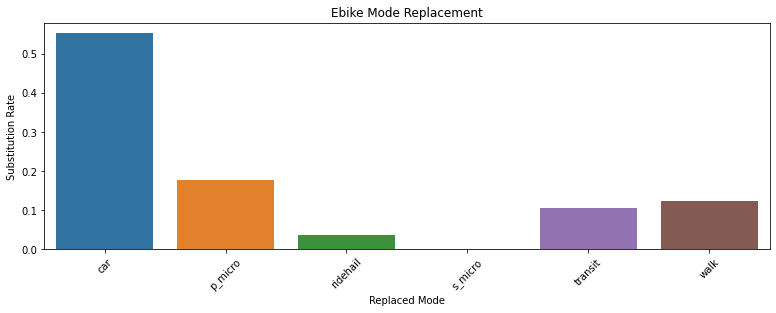

In [256]:
# Substitution rate of ebike trips not including new trips
plot_data = df_ebike_new_trips.groupby(['Replaced_mode']).count()[['Mode_confirm']].reset_index()
plot_data['subst_rate'] = plot_data['Mode_confirm'] / sum(plot_data['Mode_confirm'])

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Replaced_mode', y='subst_rate').set(title='Ebike Mode Replacement', xlabel='Replaced Mode', ylabel='Substitution Rate')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

In [257]:
# Now label the replaced mode

# Make predictions for ebike trips, that replaced a mode in the model, and compare to stated replaced mode
df_ebike = df_rep_unlabeled.drop(columns=['date_time'])
df_ebike = df_ebike[df_ebike['Mode_confirm']==6]
df_ebike_new_trips = df_ebike[~df_ebike['Replaced_mode'].isin([6,7])]

database_ebike = db.Database('openpath_trips', df_ebike_new_trips)
globals().update(database_ebike.variables)

biogeme = bio.BIOGEME(database_ebike, simulate)
biogeme.modelName = 'openpath_mnl_test'
simulatedValues = biogeme.simulate(betas)

prob_max = simulatedValues.idxmax(axis=1)
prob_max = prob_max.replace({'Prob. car': 0,
                             'Prob. p_micro': 1,
                             'Prob. ridehail':2,
                             'Prob. s_micro':3,
                             'Prob. transit':4,
                             'Prob. walk':5})
data_res = {'y_Actual':df_ebike_new_trips['Replaced_mode'],'y_Predicted': prob_max}
df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'],df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'],normalize=True)

print(round(confusion_matrix,2))
print(f"Car only: {sum(data_res['y_Actual'] == 0) / len(df_ebike_new_trips)}")
print(f"Max utility: {sum(data_res['y_Actual'] == data_res['y_Predicted']) / len(df_ebike_new_trips)}")

Predicted     0     1    3     4     5
Actual                                
0          0.55  0.00  0.0  0.00  0.00
1          0.06  0.01  0.0  0.01  0.10
2          0.00  0.00  0.0  0.02  0.01
3          0.00  0.00  0.0  0.00  0.00
4          0.06  0.00  0.0  0.02  0.03
5          0.06  0.00  0.0  0.00  0.06
Car only: 0.5519398025994332
Max utility: 0.6486856249389231


## Explore Replaced Mode Accuracy

In [49]:
# Look at av column corresponding to stated replaced mode; 1 if available
df_replaced_trips = data[~data['Replaced_mode'].isin([6,7])].copy()
replaced_list = [df_replaced_trips[str(av[x])].iloc[i] for i, x in enumerate(df_replaced_trips.Replaced_mode)]
df_replaced_trips['replaced_in_stated'] = replaced_list

# Relabel with original mode names for plotting
for mode in av:
    mode_text = '_'.join(str(av[mode]).split('_')[1:])
    df_replaced_trips['Mode_confirm'] = df_replaced_trips['Mode_confirm'].replace(mode,mode_text)
    df_replaced_trips['Replaced_mode'] = df_replaced_trips['Replaced_mode'].replace(mode,mode_text)


df_replaced_trips['Mode_confirm'] = df_replaced_trips['Mode_confirm'].replace(6,'ebike')
df_replaced_trips['Replaced_mode'] = df_replaced_trips['Replaced_mode'].replace(6,'ebike')

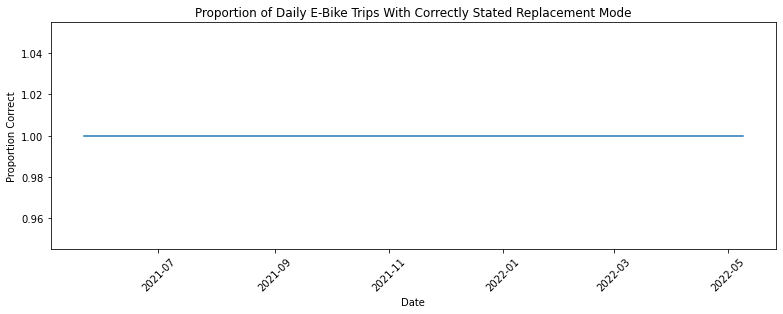

In [50]:
# Accurately stated replacement mode for all users
plot_data = df_replaced_trips[df_replaced_trips['Mode_confirm']=='ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['replaced_in_stated'].agg(['sum','count']).apply(lambda x: x.rolling(14,1).mean())
plot_data['proportion'] = plot_data['sum'] / plot_data['count']

fig, ax = plt.subplots(figsize=(13,5))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='proportion').set(title='Proportion of Daily E-Bike Trips With Correctly Stated Replacement Mode', xlabel='Date', ylabel='Proportion Correct')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

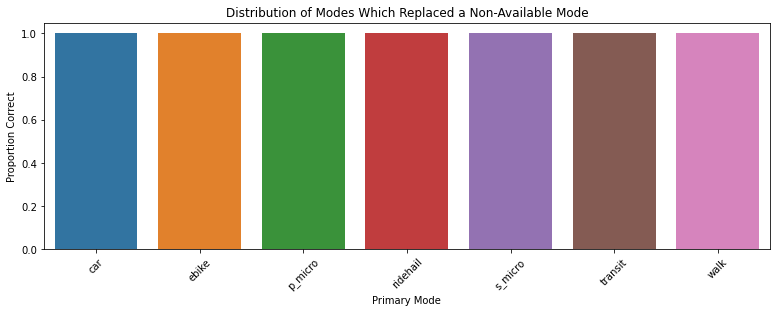

In [51]:
# Accurately stated replacement mode for all users across modes
plot_data = df_replaced_trips.groupby(['Mode_confirm'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['proportion'] = plot_data['sum'] / plot_data['count']

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Mode_confirm', y='proportion').set(title='Distribution of Modes Which Replaced a Non-Available Mode', xlabel='Primary Mode', ylabel='Proportion Correct')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

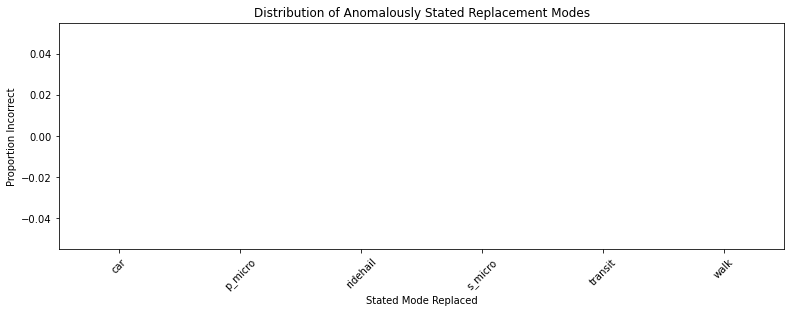

In [52]:
# Accurately stated replacement mode for all users across modes
plot_data = df_replaced_trips.groupby(['Replaced_mode'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['proportion'] = 1 - (plot_data['sum'] / plot_data['count'])

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Replaced_mode', y='proportion').set(title='Distribution of Anomalously Stated Replacement Modes', xlabel='Stated Mode Replaced', ylabel='Proportion Incorrect')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

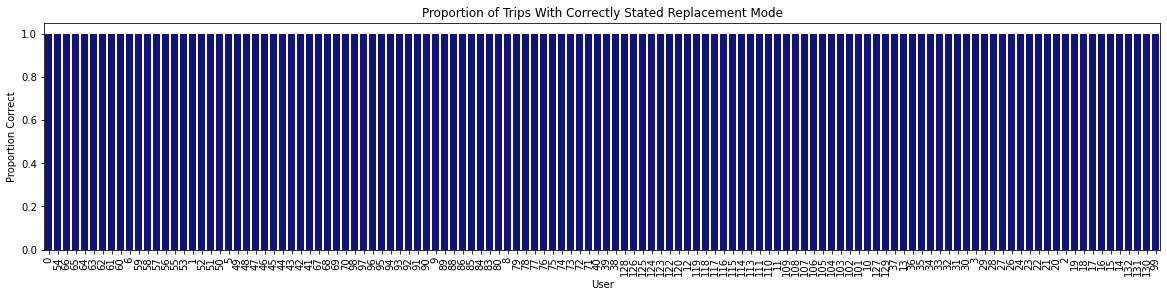

In [53]:
# Accurately stated replacement mode for all users
df_replaced_trips.user_id = df_replaced_trips.user_id.astype(str)
plot_data = df_replaced_trips.groupby(['user_id'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['proportion'] = plot_data['sum'] / plot_data['count']
plot_data = plot_data.sort_values('proportion', ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax=ax, data=plot_data, x='user_id', y='proportion', color='darkblue').set(title='Proportion of Trips With Correctly Stated Replacement Mode', xlabel='User', ylabel='Proportion Correct')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

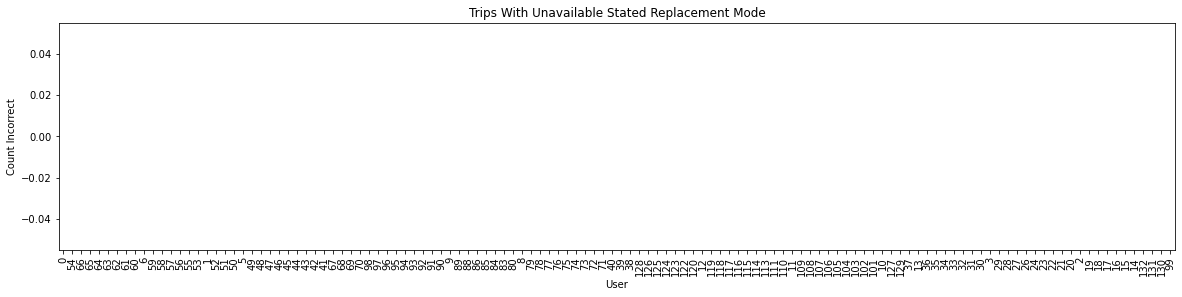

In [54]:
# Accurately stated replacement mode for all users
df_replaced_trips.user_id = df_replaced_trips.user_id.astype(str)
plot_data = df_replaced_trips.groupby(['user_id'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['incorrect'] = plot_data['count'] - plot_data['sum']
plot_data['user_id'] = plot_data['user_id'].astype(str).str[-4:]
plot_data = plot_data.sort_values('incorrect', ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax=ax, data=plot_data, x='user_id', y='incorrect', color='darkblue').set(title='Trips With Unavailable Stated Replacement Mode', xlabel='User', ylabel='Count Incorrect')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

In [55]:
len(df_replaced_trips) / len(pd.unique(df_replaced_trips.user_id))

241.13709677419354